## This Notebook handels the EMG hand gesture dataset 

Dataset can be found here: https://zenodo.org/record/7637557#.Y-q0gXbMK3A

"LSTM Recurrent Neural Network for Hand Gesture Recognition Using EMG Signals" by Toro-Ossaba, Jaramillo-Tigreros

In [518]:
abspath = "C:/Users/Finn/Documents/PlexoMotion/EMG_data/EMG hand gesture dataset"

In [519]:
# read data of the 8 subject each performing 4 gestures 
import pandas as pd 
from itertools import permutations

def read_data(subject, gesture): 
    df = pd.read_csv(abspath + "/subject " + str(subject)+ "/" + str(gesture) + ".txt", 
                     delimiter="\t", 
                     header=None, names=["Channel {}".format(x) for x in range(1, 5)])
    df["class"] = gesture
    df["subject"] = subject
    return df

n_gestures = 5
n_subjects = 8
data = pd.concat([read_data(x, y) for x in range(1, n_subjects+1) for y in range(n_gestures)], ignore_index=True)

In [520]:
# dividing each gesture-dataset in windows of 200 samples making 100 windows per gesture, 
# because each subject performs 5 gestures 500 windows per subject are reached 
# going to numpy for 3-d arrays 
import numpy as np 
from numpy.lib.stride_tricks import sliding_window_view

def window_data(array, length=200, step=None): 
    """ Please make sure sensors are on col, time in row """
    if step is None: 
        step = length
    # assert array.shape[0]%length == 0
    rows, cols = array.shape
    return sliding_window_view(array, (length, cols))[::step, 0]


datax = window_data(data[(data["class"] == 0) & (data["subject"]==1)])

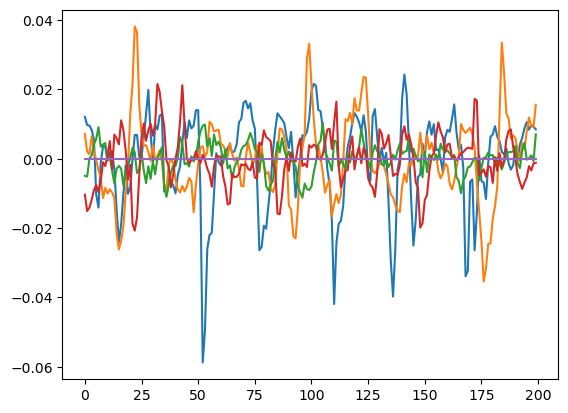

In [521]:
# plot one window 

import matplotlib.pyplot as plt

datax = datax[:, :, :4] # drop target and subject
plt.plot(datax[0])
plt.plot([np.mean(datax) for _ in range(datax.shape[1])])

(98, 200, 4)


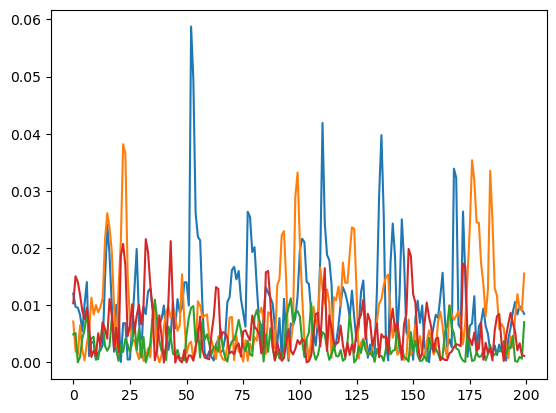

In [522]:
# preprocessing pipeline:
# 1) get abs on each window 
def absolut(array):
    return abs(array)

datax = absolut(datax)
print(datax.shape)
plt.plot(datax[0])

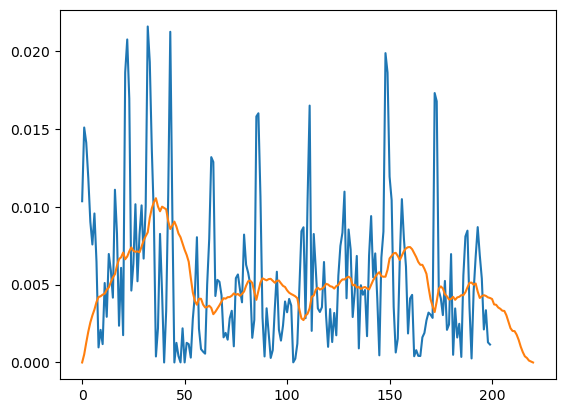

In [523]:
# 2) Moving averages 20 samples delay 

def moving_average(array, delay=20):
    # leading and post zeros 
    data = []
    zeros = np.zeros((delay, array.shape[2]))
    for window in array:
        ary = np.vstack([zeros, window, zeros])
        data.append(np.mean(sliding_window_view(ary, (delay, array.shape[2]))[:, 0], axis=1).T)
    return np.dstack(data).T

plt.plot(datax[0, :, 3])
datax = moving_average(datax, 20)
plt.plot(datax[0, :, 3])

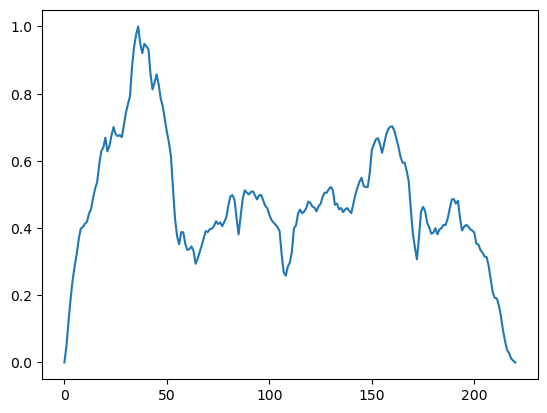

In [524]:
# nomalize to value between 0 and 1 
def normalization(array):
    data = []
    for window in array:
        for chnl in range(window.shape[1]):
            if not np.max(window[:, chnl]): 
                print(window[:, chnl])
            window[:, chnl] /= np.max(window[:, chnl])
        data.append(window.T)
    return np.dstack(data).T


datax = normalization(datax)
plt.plot(datax[0, :, 3])

In [526]:
## automate everything / Preprocessing Pipeline 
pipeline = [window_data, absolut, moving_average, normalization]
d = []
y = []

for item in [data[(data["class"] == y) & (data["subject"]==x)] 
             for x in range(1, n_subjects+1) for y in range(n_gestures)]: 
    x = item.drop(["class", "subject"], axis=1)
    class_, subject = item.at[item.index[0], "class"], item.at[item.index[0], "subject"]
    for func in pipeline: 
        x = func(x)
    # take targets and subjects 
    y.append(np.repeat([[class_, subject]], x.shape[0], axis=0))
    d.append(x)

d = np.vstack(d)
y = np.vstack(y)
y.shape, d.shape

((4095, 2), (4095, 221, 4))

In [527]:
y[0]

array([0, 1], dtype=int64)

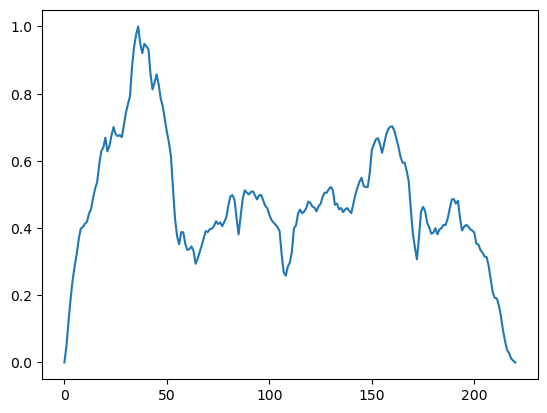

In [528]:
plt.plot(d[0, :, 3])